# Fine tuning on LFW

Import libraries and get the siamese model

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '4'
import keras, numpy as np
from models import get_siamese_model, contrastive_loss, get_compiled_siamese_model

image_size = 128

E0000 00:00:1735655723.470525    9277 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735655723.475624    9277 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
backbone_weights_path = os.path.join('Data', 'Models', 'backbone after classification', 'model.weights.h5')
siamese_model = get_siamese_model(backbone_weights_path, with_augmentation = True)

I0000 00:00:1735655725.196734    9277 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5676 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:09:00.0, compute capability: 8.6


In [3]:
siamese_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ augmentor           │ (None, 128, 128,  │          0 │ input_layer_1[0]… │
│ (Sequential)        │ 3)                │            │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_1        │ (None, 128)       │  8,903,296 │ augmentor[0][0],  │
│ (Functional)        │                   │            │ augmentor[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 1)         │          0 │ functional_1[0][… │
│                     │                   │            │ functional_1[1][… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 8,903,296 (33.96 MB)

 Trainable params: 8,893,184 (33.92 MB)

 Non-trainable params: 10,112 (39.50 KB)

Set up the model and the hyperparameters

In [4]:
learning_rate = 0.0001
weight_decay = 0.0001
batch_size = 32
siamese_model.compile(
    loss = contrastive_loss(),
    optimizer = keras.optimizers.Adam(learning_rate = learning_rate, weight_decay = weight_decay),
    metrics = ['accuracy']
)
checkpoint_path = os.path.join('Data', 'Models', 'pretrained contrastive loss model', 'model.weights.h5')


Load checkpoint weights

In [5]:
siamese_model.load_weights(checkpoint_path)

/home/thoalfeqar/anaconda3/envs/tf/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 464 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Load and preprocess lfw pairs using sklearn

In [6]:
from sklearn.datasets import fetch_lfw_pairs
import tensorflow as tf, cv2

data = fetch_lfw_pairs(subset = '10_folds', resize = 1, color = True) #use the 10 fold set

pairs = data['pairs']
targets = 1 - data['target'] #reverse the targets because we want similar pairs to have a label of 0, while dissimilar ones should have 1
images1, images2 = [], []

#resize the images
for pair in pairs:
    img1, img2 = pair
    resized1 = (cv2.resize(img1, (image_size, image_size)) * 255).astype(np.uint8) #resize and rescale
    resized2 = (cv2.resize(img2, (image_size, image_size)) * 255).astype(np.uint8) #resize and rescale
    images1.append(resized1)
    images2.append(resized2)

images1, images2 = np.array(images1), np.array(images2)

# images1 = tf.data.Dataset.from_tensor_slices(images1)
# images2 = tf.data.Dataset.from_tensor_slices(images2)
# targets = tf.data.Dataset.from_tensor_slices(targets)

# train_loader = tf.data.Dataset.zip(((images1, images2), targets)).batch(32)

Train using stratified k fold with k = 10

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score
import pickle

similarity_threshold = 0.5 #to determine if the two images belong to the same person or not
histories = [] #to save the history of each fold
fold_predictions = [] #to save the predictions
checkpoint_file = os.path.join('Data', 'training_checkpoint', 'checkpoint.bin')
sk_fold = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 100)

for i, (train_index, test_index) in enumerate(sk_fold.split(np.zeros(images1.shape[0]), targets)):

    with open(checkpoint_file, mode = 'rb') as file:
        (i_,fold_predictions) = pickle.load(file)  #load the progress from the checkpoint file

    if(i <= i_):
        continue

    print(f"Fold {i}")
    #make sure to reset the model before each fold
    siamese_model.load_weights(checkpoint_path)
    siamese_model.optimizer.learning_rate = learning_rate #to set the learning rate
    siamese_model.optimizer.weight_decay = weight_decay #to set the weight decay
    
    # prepare the training data
    train_images1 = images1[train_index]
    train_images2 = images2[train_index]
    train_labels = targets[train_index]

    #prepare the testing data
    test_images1 = images1[test_index]
    test_images2 = images2[test_index]
    test_labels = targets[test_index]

    #define the callbacks
    early_stopping = keras.callbacks.EarlyStopping(monitor = 'accuracy', patience = 6, verbose = 1, restore_best_weights = True)
    learning_rate_schedule = keras.callbacks.ReduceLROnPlateau(monitor = 'accuracy', patience = 3, factor = 0.5, verbose = 1)
 
    #train the model
    history = siamese_model.fit(
        x = [train_images1, train_images2], 
        y = train_labels,
        epochs = 10000, #let the model stop using early stopping
        batch_size = batch_size,
        callbacks = [early_stopping, learning_rate_schedule]
    )
    histories.append(history) #save the history

    #test the model
    y_pred = siamese_model.predict(
        x = [test_images1, test_images2],
        batch_size = batch_size
    )

    fold_predictions.append(y_pred.copy()) #save the prediction

    with open(checkpoint_file, 'wb') as file:
        pickle.dump((i, fold_predictions), file) #store the current fold result


    #Edit the prediction using the threshold
    y_pred[y_pred >= similarity_threshold] = 1
    y_pred[y_pred < similarity_threshold] = 0


    print(f'Accuracy: {accuracy_score(test_labels, y_pred)}')
    print(f'F1: {f1_score(test_labels, y_pred)}')

## Ten fold cross validation results

In [89]:
similarity_threshold = 0.5
predictions = np.concatenate(fold_predictions)
binary_predictions = predictions.copy()
binary_predictions[binary_predictions >= similarity_threshold] = 1
binary_predictions[binary_predictions < similarity_threshold] = 0

In [90]:
from sklearn.metrics import RocCurveDisplay, ConfusionMatrixDisplay
from matplotlib import pyplot as plt


In [91]:
new_targets = []
for (train_index, test_index) in sk_fold.split(np.zeros(images1.shape[0]), targets):
    new_targets.append(targets[test_index])

In [92]:
new_targets = np.concatenate(new_targets)

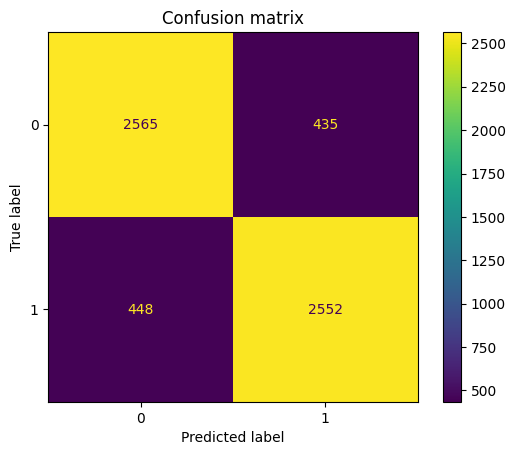

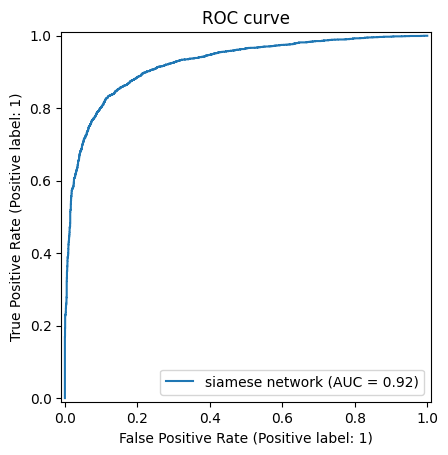

In [93]:

ConfusionMatrixDisplay.from_predictions(new_targets, binary_predictions)
plt.title('Confusion matrix')

RocCurveDisplay.from_predictions(new_targets, predictions, name = 'siamese network')
plt.title('ROC curve')
plt.show()



In [94]:
print('Accuracy: ', accuracy_score(new_targets, binary_predictions))
print('F1 score: ', f1_score(new_targets, binary_predictions))

Accuracy:  0.8528333333333333
F1 score:  0.8525137798563555


# Train on the entire dataset to obtain the final model

### Fine tune using the 10 fold split

In [ ]:
fine_tuning_checkpoint = os.path.join('Data', 'Models', 'Fine tuned model using LFW', 'model.weights.h5')
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath = fine_tuning_checkpoint, 
    monitor = 'accuracy', 
    save_weights_only = True,
    save_best_only = True,
    verbose = 1
)
learning_rate_schedule = keras.callbacks.ReduceLROnPlateau(monitor = 'accuracy', factor = 0.5, patience = 3, verbose = 1)
early_stopping = keras.callbacks.EarlyStopping(monitor = 'accuracy', patience = 10)

siamese_model.load_weights(fine_tuning_checkpoint)
siamese_model.fit(
    x = [images1, images2],
    y = targets,
    batch_size = batch_size,
    epochs = 10000, #stop with early stopping
    callbacks = [checkpoint_callback, learning_rate_schedule, early_stopping]
)


### Fine tune using the custom dataloader

In [8]:
from DataLoaders import DataLoaderContrastive

train_loader = DataLoaderContrastive(
    dataset_root_path = os.path.join('Data', 'LFW', 'lfw_augmented'),
    batch_size = 32,
    positive_ratio = 0.2,
    image_size = (128, 128)
)

siamese_model = get_compiled_siamese_model()
siamese_model.load_weights(fine_tuning_checkpoint)


In [ ]:
siamese_model.fit(
    x = train_loader,
    batch_size = 32,
    epochs = 10000,
    callbacks = [checkpoint_callback, learning_rate_schedule, early_stopping]
)

In [3]:
from DataLoaders import load_img
from models import get_compiled_siamese_model
import os, numpy as np

siamese_model = get_compiled_siamese_model(
    os.path.join('Data', 'Models', 'Fine tuned model using LFW', 'model.weights.h5')
)

image1 = np.expand_dims(load_img(os.path.join('Data', 'images', 'henry cropped.png'), image_size = (128, 128)), axis = 0).astype(np.uint8)
image2 = np.expand_dims(load_img(os.path.join('Data', 'images', 'henry cropped2.png'), image_size = (128, 128)), axis = 0).astype(np.uint8)

siamese_model.predict(x = [image1, image2])


/home/thoalfeqar/anaconda3/envs/tf/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_521', 'keras_tensor_522']. Received: the structure of inputs=('*', '*')
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


array([[0.48041457]], dtype=float32)

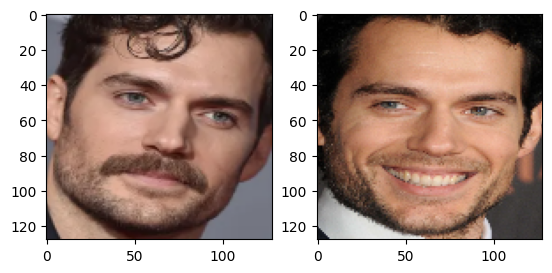

In [5]:
from matplotlib import pyplot as plt
plt.subplot(1, 2, 1)
plt.imshow(image1[0])
plt.subplot(1, 2, 2)
plt.imshow(image2[0])
plt.show()